两个原则：  
- **平移不变性**-分类器不会受图片像素位置影响
- **局部性**-只需要关注局部信息

对全连接层使用平移不变性和局部性得到卷积层  
卷积层是一个特殊的全连接层  
**核参数很小**（3x3,5x5），不会受输入大小影响  

## 卷积层
二维交叉相关-对应相乘再相加  
卷积核Kernel--卷积的W  
核不变，与输入位置无关--平移不变性  
输出只与部分输入（核窗口）有关--局部性  

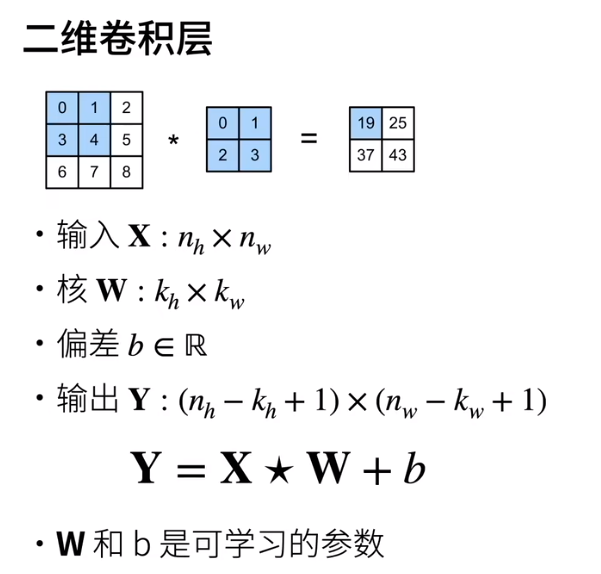

不同的卷积核会带来不同的效果  
核矩阵的大小是超参数

一维交叉相关-文本、语言、时序序列  
三维交叉相关-视频、医学图像、气象地图

In [2]:
import torch
from torch import nn
from d2l import torch as d2l

def corr2d(X, K):
    '''计算二维互相关运算'''
    h, w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i,j] = (X[i:i+h, j:j+w] * K).sum() # * 点积
    return Y


# 卷积层
class Conv2D(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.weight = nn.Parameter(torch.rand(kernel_size))
        self.bias = nn.Parameter(torch.zeros(1))  # 标量

    def forward(self, x):
        return corr2d(x, self.weight) + self.bias

In [ ]:
# 应用：检测图像中不同颜色的边缘
X = torch.ones((6, 8))
X[:,2:6] = 0

K = torch.tensor([[1.0, -1.0]])  # 若两元素未变，输出是0；否则为1或-1

Y = corr2d(X, K)  # 检测出边界

# K只能检测垂直边缘
corr2d(X.t(), K)


In [ ]:
# 给定X与Y，学习K
conv2d = nn.Conv2d(1, 1, kernel_size=(1, 2), bias=False)  # 输出通道、输入通道

X = X.reshape((1, 1, 6, 8))  # （批量大小、通道、高度、宽度）
Y = Y.reshape((1, 1, 6, 7))
lr = 3e-2

for i in range(10):
    Y_hat = conv2d(X)
    l = (Y_hat - Y)**2
    conv2d.zero_grad()
    l.sum().backward()
    conv2d.weight.data[:] -= lr * conv2d.weight.grad  # 梯度下降
    if (i + 1) % 2 == 0:
        print(f'batch {i+1}, loss {l.sum():.3f}')

# 所学卷积核
conv2d.weight.data.reshape((1, 2))

QA

## 填充和步幅
控制输出大小的超参数

### 填充
更大的卷积核更快地减小输出大小--导致卷积核不能再使用，且会限制层数

在输入周围添加额外的行/列

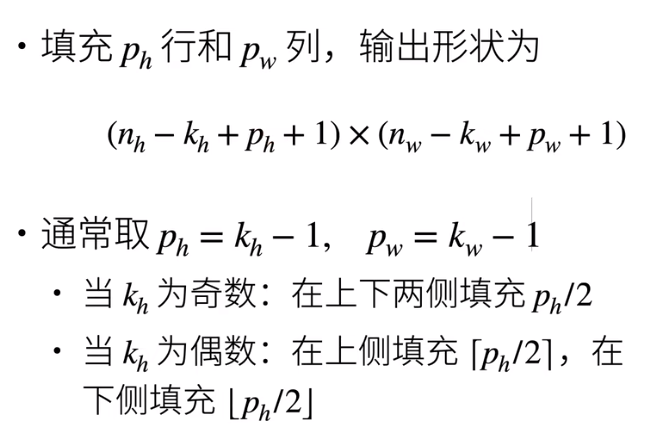

### 步幅
填充减小的输出大小与层数**线性相关**  
若输入很大，需要大量计算才能得到较小输出

步幅是指行/列的滑动步长（通常取2）  
可以**成倍**减小输出形状

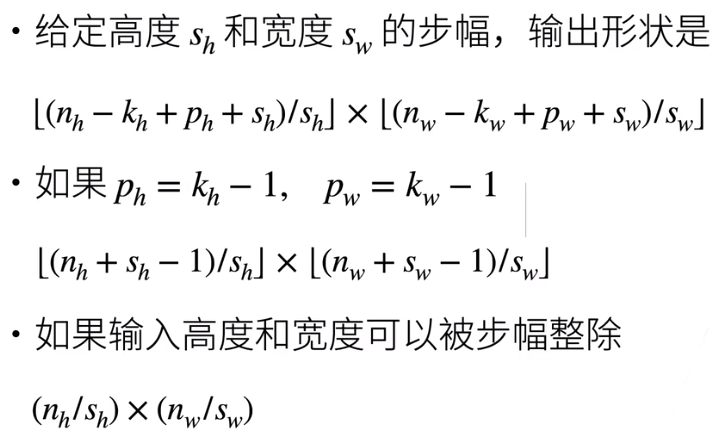


In [ ]:
import torch
from torch import nn

# 在所有侧边填充1个像素
def comp_conv2d(conv2d, X):
    X = X.reshape((1, 1) + X.shape)
    Y = conv2d(X)
    return Y.reshape(Y.shape[2:])

conv2d = nn.Conv2d(1, 1, kernel_size=3, padding=1)  # 上下左右各填充1行
X = torch.rand(size=(8, 8))
comp_conv2d(conv2d, X).shape

# 填充不同的高度和宽度
conv2d = nn.Conv2d(1, 1, kernel_size=(5, 3), padding=(2, 1))
comp_conv2d(conv2d, X).shape

# 将高度和宽度的步幅设置为2
conv2d = nn.Conv2d(1, 1, kernel_size=3, padding=1, stride=2)
comp_conv2d(conv2d, X).shape

# 稍微复杂一点
conv2d = nn.Conv2d(1, 1, kernel_size=(3, 5), padding=(0, 1), stride=(3, 4))
comp_conv2d(conv2d, X).shape

QA

## 多输入输出通道
输出通道数是超参数
### 多个输入通道
每个通道都有一个**二维卷积核**，结果是所有通道卷积结果按元素相加的**和**  
每个通道有自己的偏移--向量
### 多个输出通道
多个**三维卷积核**，每个核生成一个输出通道  
每个通道有自己的偏移

每个输出通道可以识别特定模式（颜色、纹理、边缘）  
输入通道核识别并组合输入（前一层的输出）中的模式（猫眼睛、猫耳朵...）

### 1x1卷积层
不识别空间模式，只是**融合通道**  
相当于一个全连接层

In [ ]:
import torch 
from d2l import torch as d2l

# 多输入通道互相关运算
def corr2d_multi_in(X, K):  # 3d
    return sum(d2l.corr2d(x, k) for x, k in zip(X, K))  # 对输入通道维度遍历

X = torch.tensor([[[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]],
                  [[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]]])
K = torch.tensor([[[0.0, 1.0], [2.0, 3.0]], 
                  [[1.0, 2.0], [3.0, 4.0]]])
corr2d_multi_in(X, K)

# 多输出通道的互相关运算
def corr2d_multi_in_out(X, K):  # 3d 4d
    return torch.stack([corr2d_multi_in(X, k) for k in K], 0)  # k是3d

K = torch.stack((K, K+1, K+2), 0)  # 三个输出通道，在第0维stack
K.shape
corr2d_multi_in_out(X, K)

# 1x1卷积
def corr2d_multi_in_out_1x1(X, K): 
    c_i, h, w = X.shape
    c_o = K.shape[0]
    X = X.reshape((c_i, h*w))
    K = K.reshape((c_o, c_i))
    Y = torch.matmul(K, X)
    return Y.reshape((c_o, h, w))

X = torch.normal(0, 1, (3, 3, 3))
K = torch.normal(0, 1, (2, 3, 1, 1))  # 输入是3，输出是2

Y1 = corr2d_multi_in_out_1x1(X, K)
Y2 = corr2d_multi_in_out(X, K)
assert float(torch.abs(Y1-Y2).sum()) < 1e-6  # Y1==Y2



QA

## 池化层
卷积层对**位置**非常**敏感**  
1个像素移位都会导致不好的输出  
需要一定程度的平移不变性，轻微抖动（光线、位置、比例）不会影响输出

池化层具有窗口大小、填充和步幅超参数  
**没有可学习的参数**  
在每个输入通道应用池化层  
**输出通道数==输入通道数**

Max Pooling：返回滑动窗口中的最大值  
每个窗口中最强的模式信号

Avg Pooling：平均操作

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

# 池化层的正向传播
def pool2d(X, pool_size, mode='max'):
    p_h, p_w = pool_size
    Y = torch.zeros((X.shape[0] - p_h + 1, X.shape[1] - p_w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if mode == 'max':
                Y[i, j] = X[i:i+p_h, j:j+p_w].max()
            elif mode == 'avg':
                Y[i, j] = X[i:i+p_h, j:j+p_w].mean()

    return Y

# 验证
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
pool2d(X, (2, 2))
pool2d(X, (2, 2), 'avg')

In [ ]:
# 填充和步幅
X = torch.arange(16, dtype=torch.float32).reshape((1, 1, 4, 4))
# 深度学习框架中步幅与池化窗口的大小相同
pool2d = nn.MaxPool2d(3)  # 3x3窗口
pool2d(X)

pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

pool2d = nn.MaxPool2d((2, 3), padding=(1, 1), stride=(2, 3))
pool2d(X)

# 池化层在每个输入通道上单独运算
X = torch.cat((X, X+1), 1)  # (1,2,4,4)
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

QA

## 经典卷积神经网络-LeNet
MNIST数字手写体数据集

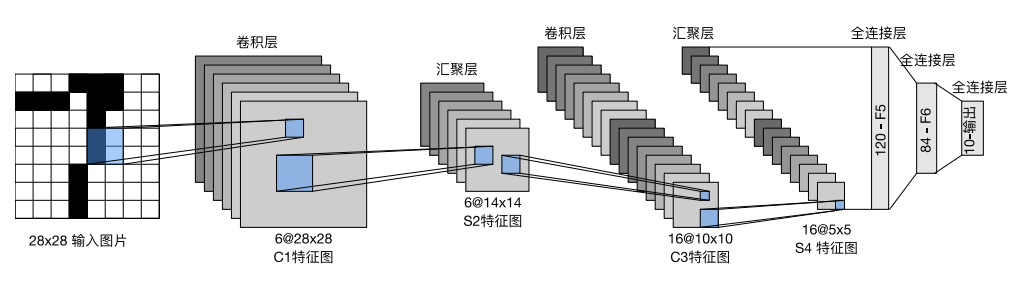

LeNet是早期成功的神经网络  
先使用**卷积层**学习图片空间信息，然后使用**全连接层**转换到类别空间

In [ ]:
# LeNet由两个部分组成：卷积编码器和全连接层密集块
import torch
from torch import nn
from d2l import torch as d2l

class Reshape(nn.Module):
    def forward(self, x):
        return x.view(-1, 1, 28, 28)  # 批量数不变
    
net = nn.Sequential(
    Reshape(),  # 输入
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),  # 第一个批量维度不变，其余拉成一个向量
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10))

# 卷积压缩空间信息，将抽出的信息放在不同的通道里，通道增加
# MLP通过隐藏层平滑地压缩向量


In [ ]:
# 检查模型
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)


In [ ]:
# LeNet在Fashion-MNIST数据集上的表现
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

# 轻微修改evaluate_accuracy函数
def evaluate_accuracy_gpu(net, data_iter, device=None):
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net, nn.Module):
        net.eval() # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device  # 看第一个参数的device
    # 正确预测的数量，总预测的数量
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        if isinstance(X, list):
            # BERT微调所需的（之后将介绍）
            X = [x.to(device) for x in X]
        else:
            X = X.to(device)
        y = y.to(device)
        metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]


def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches, (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, 'f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec 'f'on {str(device)}')

In [ ]:
# 训练和评估
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())
# 没有过拟合很有可能就是欠拟合了

QA